In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import pybullet as p
import pybullet_data 
import time
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F

In [2]:
physicsClient = p.connect(p.GUI)

In [3]:
p.setGravity(0,0,-10) 
p.resetSimulation() 
p.setAdditionalSearchPath(pybullet_data.getDataPath()) 
planeId = p.loadURDF("plane.urdf") 
robotId = p.loadURDF("iiwa7.urdf",flags=9, useFixedBase=1)

robotStartPos = [0,0,0]
robotStartOrientation = p.getQuaternionFromEuler([0,0,0])

p.resetBasePositionAndOrientation(robotId,robotStartPos,robotStartOrientation)

p.setJointMotorControlArray(robotId,range(7),p.VELOCITY_CONTROL,forces=np.zeros(7))

In [79]:
a=1
horizon_length = 40
Q2=0.1*np.eye(14)
Q1=1000*np.eye(14)
for i in range(7,14):
    Q1[i,i]=0.1
Q=[]
for i in range(horizon_length+1):
    if (i==horizon_length):
        Q.append(Q1)
    else:
        Q.append(Q2)

R=0.01*np.eye(7)
sigma=15
C=np.eye(14)
Sigma=1*np.eye(14)


u_bar = np.zeros([7, horizon_length])
U = np.zeros([7, horizon_length])
Z = np.zeros([14,horizon_length+1])
u= np.zeros([7, horizon_length])
    
      
z_bar=np.zeros([14,horizon_length+1])
target_p = np.array([1,0.5,1])
robotEndOrientation = p.getQuaternionFromEuler([0,0,0])
targetPositionsJoints = p.calculateInverseKinematics(robotId,7,target_p,targetOrientation = robotEndOrientation)
p.setJointMotorControlArray(robotId,range(7),p.POSITION_CONTROL,targetPositions = targetPositionsJoints)
z_bar[0:7,horizon_length]=targetPositionsJoints
#for i in range (100):
#    p.stepSimulation()
#for i in range(7):
#    z_bar[i,1000]=p.getJointStates(robotId,range(7))[i][0]
#for i in range(7):
#    z_bar[i+7,1000]=p.getJointStates(robotId,range(7))[i][1]


In [5]:
def simulate_system(x, u):
    x_next=[]
    for i in range(7):
        p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])
    
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces=u)
    p.stepSimulation()
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][0])
    for i in range(7):
        x_next.append(p.getJointStates(robotId,range(7))[i][1])
    x_next = np.array(x_next)
    return x_next
    
    

In [6]:
def get_linearization(current_state, control_signal):
    eps = 1e-5
    A = np.zeros([len(current_state), len(current_state)])
    for ii in range(len(current_state)):
        x = current_state.copy()
        x[ii] += eps
        x_inc = simulate_system(x, control_signal)  
        x = current_state.copy()
        x[ii] -= eps
        x_dec = simulate_system(x, control_signal)
        A[:,ii] = (x_inc - x_dec) / (2 * eps)
 
    B = np.zeros([len(current_state), len(control_signal)])
    for ii in range(len(control_signal)):
        u = control_signal.copy()
        u[ii] += eps
        x_inc = simulate_system(current_state, u)
        u = control_signal.copy()
        u[ii] -= eps
        x_dec = simulate_system(current_state, u)
        B[:,ii] = (x_inc - x_dec) / (2 * eps)
    return A, B

In [7]:
def solve_ricatti_equations(Z,U,Q,R,N,q,r):
    
    
    K_gains = []
    k_feedforward = []
    S = Q[-1]
    s = q[-1]
       
    for i in reversed(range(horizon_length)):
        A, B = get_linearization(Z[:,i], U[:,i])
        W = np.linalg.inv(Sigma)-sigma*C.T.dot(S).dot(C)
        iW = np.linalg.inv(W)
        term_covar = C.dot(iW).dot(C.T)
        H = R + B.T.dot(S).dot(B) + sigma * B.T.dot(S.T).dot(term_covar).dot(S).dot(B)
        g = r[i] + B.T.dot(s) + sigma * B.T.dot(S.T).dot(term_covar).dot(s)
        G = B.T.dot(S).dot(A) + sigma * B.T.dot(S.T).dot(term_covar.T).dot(S).dot(A)
        k = -np.linalg.solve(H,g)
        K = -np.linalg.solve(H,G)
        s = q[i] + A.T.dot(s) + G.T.dot(k) + K.T.dot(g) + K.T.dot(H).dot(k) + sigma * A.T.dot(S.T).dot(term_covar).dot(s)
        S = Q[i] + A.T.dot(S).dot(A) + K.T.dot(H).dot(K) + G.T.dot(K) + K.T.dot(G) + sigma * A.T.dot(S.T).dot(term_covar).dot(S).dot(A)
      
        K_gains.append(K)
        k_feedforward.append(k)
        
       
    K_gains = K_gains[::-1]
    k_feedforward = k_feedforward[::-1]
    return K_gains, k_feedforward

In [8]:
def controller(Z,U,q,r,horizon_length,Q,R,alpha):
    state2=np.empty([14, horizon_length+1])
    z0 = np.zeros([14,])
    state2[:,0] = z0
    u2 = np.zeros([7, horizon_length])
    K,k = solve_ricatti_equations(Z,U,Q,R,horizon_length,q,r)
    for i in range(horizon_length):
        u2[:,i] = U[:,i] + K[i] @ (state2[:,i] - Z[:,i])+ alpha*k[i]
        state2[:,i+1] = simulate_system(state2[:,i], u2[:,i])
   
   
        
    
    state=state2.copy()
    u=u2.copy()
    return state,u,k

In [9]:
def compute_cost(Z,U,z_bar,u_bar, horizon_length):
    J=((Z[:,horizon_length]-z_bar[:,horizon_length]).T)@ Q[horizon_length] @(Z[:,horizon_length]-z_bar[:,horizon_length])
    for i in range(horizon_length):
        J=J+((Z[:,i]-z_bar[:,i]).T)@ Q[i] @(Z[:,i]-z_bar[:,i])+((U[:,i]-u_bar[:,i]).T @ R @ (U[:,i]-u_bar[:,i]))
    
    return J

In [10]:
def get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar):
    q=[]
    r=[]
    J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
    #J=J+0.5*((z[:,horizon_length]-Z[:,horizon_length]).T)@ Q[horizon_length] @(z[:,horizon_length]-Z[:,horizon_length])+2*(z[:,horizon_length].T-z_bar[:,horizon_length].T)@Q[horizon_length]@(z[:,horizon_length]-Z[:,horizon_length])
    for i in range(horizon_length):
        #J=J+0.5*((u[:,i]-U[:,i]).T)@ R @(u[:,i]-U[:,i])+0.5*((z[:,i]-Z[:,i]).T)@ Q[i] @(z[:,i]-Z[:,i])+2*((z[:,i]-z_bar[:,i]).T)@Q[i]@(z[:,i]-Z[:,i])+2*((u[:,i]-u_bar[:,i]).T)@R@(u[:,i]-U[:,i])    
        q1=2*(Z[:,i]-z_bar[:,i]).T@Q[i]
        q.append(q1)
        r1=2*(U[:,i]-u_bar[:,i]).T@R
        r.append(r1)
    
    return q,r

In [80]:
q,r=get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar)
state,u,k = controller(Z,U,q,r,horizon_length,Q,R,a)
U = u
Z = np.zeros([14, horizon_length+1])
for i in range(horizon_length):
    Z[:,i+1] = simulate_system(Z[:,i], U[:,i])
J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
J1=J
print(J)

q,r=get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar)
state,u,k = controller(Z,U,q,r,horizon_length,Q,R,a)
U = u
Z = np.zeros([14, horizon_length+1])
for i in range(horizon_length):
    Z[:,i+1] = simulate_system(Z[:,i], U[:,i])
J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
J1=J
print(J)

for j in range(50):
    q,r=get_quadratic_approximation_cost(Z,U, horizon_length,z_bar,u_bar)
    state,u,k = controller(Z,U,q,r,horizon_length,Q,R,a)
    U = u
    Z = np.zeros([14, horizon_length+1])
    for i in range(horizon_length):
        Z[:,i+1] = simulate_system(Z[:,i], U[:,i])
    J=compute_cost(Z,U,z_bar,u_bar, horizon_length)
    print(J)
    if (J<=J1):
        if (abs(J1-J)<1e-13):
            print("iteration converged")
            #break
        J1=J
    else:
        a=a/2
        J1=J
        print(a)

791.4752786403673
791.4752759049601
791.4752786404607
0.5
791.47522228164
791.4752222817829
0.25
791.4752222817217
791.4752222817095
791.4752222817331
0.125
791.4752222817044
791.4752222817108
0.0625
791.4752222817096
791.4752222817107
0.03125
791.4752222817083
791.4752222817079
791.4752222817098
0.015625
791.4752222817077
791.4752222817061
791.4752222817062
0.0078125
791.4752222817057
791.4752222817046
791.4752222817043
791.4752222817032
791.4752222817023
791.4752222817029
0.00390625
791.4752222817028
791.475222281703
0.001953125
791.4752222817028
791.4752222817027
791.4752222817028
0.0009765625
791.4752222817028
iteration converged
791.4752222817026
791.4752222817026
iteration converged
791.4752222817026
iteration converged
791.4752222817026
iteration converged
791.4752222817026
iteration converged
791.4752222817026
iteration converged
791.4752222817025


KeyboardInterrupt: 

In [75]:
gain=k
g0_list =[]
g1_list =[]
g2_list =[]
g3_list =[]
g4_list =[]
g5_list =[]
g6_list =[]
g7_list =[]
g8_list =[]
g9_list =[]
g10_list =[]
g11_list =[]
g12_list =[]
g13_list =[]
for i in gain:
    for a in range(14):
        j = np.empty([14,1])
        j[:,0]=sum(i)

        if a ==0:
            g0 = j[0]
            g0_list.append(g0)
        if a ==1:
            g1 = j[1]
            g1_list.append(g1)
        if a ==2:
            g2 = j[2]
            g2_list.append(g2)
        if a ==3:
            g3 = j[3]
            g3_list.append(g3)
        if a ==4:
            g4 = j[4]
            g4_list.append(g4)
        if a ==5:
            g5 = j[5]
            g5_list.append(g5)
        if a ==6:
            g6 = j[6]
            g6_list.append(g6)
        if a ==7:
            g7 = j[7]
            g7_list.append(g7)
        if a ==8:
            g8 = j[8]
            g8_list.append(g8)
        if a ==9:
            g9 = j[9]
            g9_list.append(g9)
        if a ==10:
            g10 = j[10]
            g10_list.append(g10)
        if a ==11:
            g11 = j[11]
            g11_list.append(g11)
        if a ==12:
            g12 = j[12]
            g12_list.append(g12)
        if a ==13:
            g13 = j[13]
            g13_list.append(g13)

In [22]:
gain=k
g0_list1 =[]
g1_list1 =[]
g2_list1 =[]
g3_list1 =[]
g4_list1 =[]
g5_list1 =[]
g6_list1 =[]
g7_list1 =[]
g8_list1 =[]
g9_list1 =[]
g10_list1 =[]
g11_list1 =[]
g12_list1 =[]
g13_list1 =[]
for i in gain:
    for a in range(14):
        j = np.empty([14,1])
        j[:,0]=sum(i)

        if a ==0:
            g0 = j[0]
            g0_list1.append(g0)
        if a ==1:
            g1 = j[1]
            g1_list1.append(g1)
        if a ==2:
            g2 = j[2]
            g2_list1.append(g2)
        if a ==3:
            g3 = j[3]
            g3_list1.append(g3)
        if a ==4:
            g4 = j[4]
            g4_list1.append(g4)
        if a ==5:
            g5 = j[5]
            g5_list1.append(g5)
        if a ==6:
            g6 = j[6]
            g6_list1.append(g6)
        if a ==7:
            g7 = j[7]
            g7_list1.append(g7)
        if a ==8:
            g8 = j[8]
            g8_list1.append(g8)
        if a ==9:
            g9 = j[9]
            g9_list1.append(g9)
        if a ==10:
            g10 = j[10]
            g10_list1.append(g10)
        if a ==11:
            g11 = j[11]
            g11_list1.append(g11)
        if a ==12:
            g12 = j[12]
            g12_list1.append(g12)
        if a ==13:
            g13 = j[13]
            g13_list1.append(g13)

In [81]:
gain=k
g0_list2 =[]

for i in gain:
    for a in range(14):
        j = np.empty([14,1])
        j[:,0]=sum(i)

        if a ==0:
            g0 = j[0]
            g0_list2.append(g0)
       

In [62]:
gain=k
g0_list3 =[]

for i in gain:
    for a in range(14):
        j = np.empty([14,1])
        j[:,0]=sum(i)

        if a ==0:
            g0 = j[0]
            g0_list3.append(g0)
       

(40, 1)


<IPython.core.display.Javascript object>


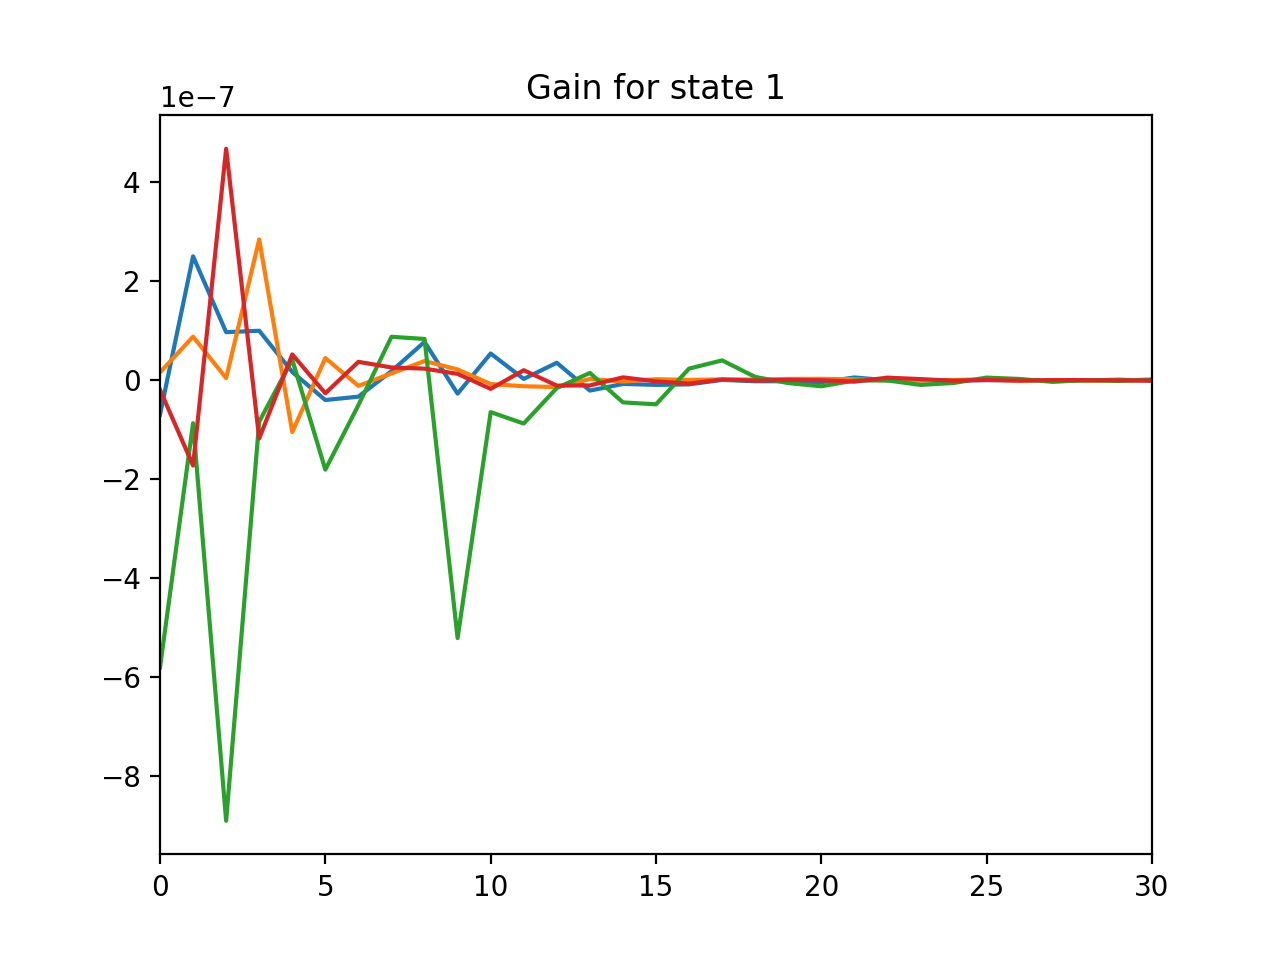

Text(0.5, 1.0, 'Gain for state 1')

In [82]:
print(np.shape(g0_list))
plt.figure()
plt.plot(np.arange(horizon_length),g0_list,np.arange(horizon_length),g0_list1,np.arange(horizon_length),g0_list2,np.arange(horizon_length),g0_list3)
plt.xlim(0,30)
plt.title('Gain for state 1')


In [14]:
x = np.zeros([14,1])
for i in range(7):
    p.resetJointState(robotId,i,x[i],targetVelocity = x[i+7])

In [15]:
xe=[]
for i in range(horizon_length):
    p.setJointMotorControlArray(robotId,range(7), controlMode=p.TORQUE_CONTROL,forces= u[:,i])
    xe.append(p.getLinkState(robotId,7)[0])
    p.stepSimulation()
print(xe)

[(0.09999999999999991, 1.8041124150158794e-16, 1.196), (0.09999999999999991, 1.8041124150158794e-16, 1.196), (0.18087010629160125, 0.004134683690080361, 1.191913948059498), (0.2550119928267718, 0.015022443982016492, 1.1808400437245634), (0.3198262091120894, 0.030440536245011498, 1.1649476852805678), (0.375878501552266, 0.04863632520051583, 1.1459513905688223), (0.42401245517361946, 0.06828971591626272, 1.1251519772941412), (0.46514132461783364, 0.088437614669623, 1.1035202970652431), (0.500165776252064, 0.10840100624486418, 1.0817659467124776), (0.5299283478381132, 0.1277200322858647, 1.060394862210117), (0.5551909325703603, 0.14609963809108795, 1.039756396641207), (0.5766267821354654, 0.16336590820972807, 1.0200810229820867), (0.5948212161069243, 0.17943201042324672, 1.0015100729358304), (0.6102771824213848, 0.1942722292963951, 0.9841189175858832), (0.6234231935687804, 0.207902532540183, 0.9679348603209731), (0.63462210591975, 0.22036626259349523, 0.9529508304714664), (0.6441798371934